# Data Wrangling, Analysis and Visualisation using Twitter API for WeRateDogs Dataset

## Data Wrangling

### Gather

In [4]:
#importing the required libaries
import pandas as pd
import numpy as np
import tweepy 
import requests
import json
from timeit import default_timer as timer
from tweepy import OAuthHandler

In [5]:
#Tweet text max 140 charectors plus 3 for pandas
pd.options.display.max_colwidth = 143

In [8]:
#importing twitter_archive_enhanced.csv 
t_archive = pd.read_csv('twitter-archive-enhanced.csv', sep = ',')
t_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1042,743895849529389061,NaN,NaN,2016-06-17 19:59:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're given AUX cord privileges from the back seat and accidentally start blasting an audiobook... both 10/10 https://t.co/gCCrY8P0K9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743895849529389061/photo/1,10,10,None,None,None,None,None
146,863471782782697472,NaN,NaN,2017-05-13 19:11:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Say hello to Quinn. She's quite the goofball. Not even a year old. Confirmed 13/10 but she really needs your help \n\nhttps://…,8.630625e+17,4.196984e+09,2017-05-12 16:05:02 +0000,"https://www.gofundme.com/helpquinny,https://twitter.com/dog_rates/status/863062471531167744/photo/1,https://twitter.com/dog_rates/status/86...",13,10,Quinn,None,None,None,None
2269,667509364010450944,NaN,NaN,2015-11-20 01:06:48 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667509364010450944/photo/1,12,10,None,None,None,None,None
1095,736392552031657984,NaN,NaN,2016-05-28 03:04:00 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Say hello to mad pupper. You know what you did. 13/10 would pet until no longer furustrated https://t.co/u1ulQ5heLX,NaN,NaN,NaN,https://vine.co/v/iEggaEOiLO3,13,10,mad,None,None,pupper,None
645,793165685325201412,NaN,NaN,2016-10-31 19:00:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Benji. He's Air Bud. It's a low effort costume but he pulls it off rather h*ckin well. 12/10 would happily get dunked on https://t....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793165685325201412/photo/1,12,10,Benji,None,None,None,None


In [9]:
# downloading image_predictions.tsv file programatically
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image_predictions.tsv', 'wb')as f:
    f.write(response.content)

In [11]:
t_image = pd.read_csv('image_predictions.tsv', sep = "\t")
t_image.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1742,822647212903690241,https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg,1,Samoyed,0.416769,True,malamute,0.252706,True,kuvasz,0.157028,True
1133,728409960103686147,https://pbs.twimg.com/media/ChvU_DwWMAArx5L.jpg,1,Siamese_cat,0.478278,False,Saint_Bernard,0.094246,True,king_penguin,0.082157,False
460,674793399141146624,https://pbs.twimg.com/media/CV1ZA3oWEAA1HW_.jpg,1,giant_schnauzer,0.119693,True,Afghan_hound,0.072763,True,miniature_schnauzer,0.063786,True
727,686377065986265092,https://pbs.twimg.com/media/CYaAS2kUoAINkye.jpg,1,German_shepherd,0.830816,True,Leonberg,0.076325,True,bloodhound,0.037449,True
951,704871453724954624,https://pbs.twimg.com/media/Ccg02LiWEAAJHw1.jpg,1,Norfolk_terrier,0.689504,True,soft-coated_wheaten_terrier,0.101480,True,Norwich_terrier,0.055779,True


In [17]:
#twitter api connection
consumer_key = 'x'
consumer_secret = 'x'
access_token = 'x'
access_secret = 'x'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True)


In [13]:
tweet_ids = t_archive.tweet_id.values
len(tweet_ids)

2356

In [16]:
count = 0
fails = {}
start = timer()

with open('tweet_json.txt', 'w') as file:
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode="extended")
            print("success")
            json.dump(tweet._json, file)
            file.write('\n')
        except tweepy.TweepError as e:
            print('fail')
            fails[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails)

1: 892420643555336193
success
2: 892177421306343426
success
3: 891815181378084864
success
4: 891689557279858688
success
5: 891327558926688256
success
6: 891087950875897856
success
7: 890971913173991426
success
8: 890729181411237888
success
9: 890609185150312448
success
10: 890240255349198849
success
11: 890006608113172480
success
12: 889880896479866881
success
13: 889665388333682689
success
14: 889638837579907072
success
15: 889531135344209921
success
16: 889278841981685760
success
17: 888917238123831296
success
18: 888804989199671297
success
19: 888554962724278272
success
20: 888202515573088257
fail
21: 888078434458587136
success
22: 887705289381826560
success
23: 887517139158093824
success
24: 887473957103951883
success
25: 887343217045368832
success
26: 887101392804085760
success
27: 886983233522544640
success
28: 886736880519319552
success
29: 886680336477933568
success
30: 886366144734445568
success
31: 886267009285017600
success
32: 886258384151887873
success
33: 8860541600590725

fail
262: 842846295480000512
success
263: 842765311967449089
success
264: 842535590457499648
success
265: 842163532590374912
success
266: 842115215311396866
success
267: 841833993020538882
success
268: 841680585030541313
success
269: 841439858740625411
success
270: 841320156043304961
success
271: 841314665196081154
success
272: 841077006473256960
success
273: 840761248237133825
success
274: 840728873075638272
success
275: 840698636975636481
success
276: 840696689258311684
success
277: 840632337062862849
success
278: 840370681858686976
success
279: 840268004936019968
success
280: 839990271299457024
success
281: 839549326359670784
success
282: 839290600511926273
success
283: 839239871831150596
success
284: 838952994649550848
success
285: 838921590096166913
success
286: 838916489579200512
success
287: 838831947270979586
success
288: 838561493054533637
success
289: 838476387338051585
success
290: 838201503651401729
success
291: 838150277551247360
success
292: 838085839343206401
success
293

success
519: 810657578271330305
success
520: 810284430598270976
success
521: 810254108431155201
success
522: 809920764300447744
success
523: 809808892968534016
success
524: 809448704142938112
success
525: 809220051211603969
success
526: 809084759137812480
success
527: 808838249661788160
success
528: 808733504066486276
success
529: 808501579447930884
success
530: 808344865868283904
success
531: 808134635716833280
success
532: 808106460588765185
success
533: 808001312164028416
success
534: 807621403335917568
success
535: 807106840509214720
success
536: 807059379405148160
success
537: 807010152071229440
success
538: 806629075125202948
success
539: 806620845233815552
success
540: 806576416489959424
success
541: 806542213899489280
success
542: 806242860592926720
success
543: 806219024703037440
success
544: 805958939288408065
success
545: 805932879469572096
success
546: 805826884734976000
success
547: 805823200554876929
success
548: 805520635690676224
success
549: 805487436403003392
success


success
776: 776201521193218049
success
777: 776113305656188928
success
778: 776088319444877312
success
779: 775898661951791106
success
780: 775842724423557120
success
781: 775733305207554048
success
782: 775729183532220416
success
783: 775364825476165632
success
784: 775350846108426240
success
785: 775096608509886464
fail
786: 775085132600442880
success
787: 774757898236878852
success
788: 774639387460112384
success
789: 774314403806253056
success
790: 773985732834758656
success
791: 773922284943896577
success
792: 773704687002451968
success
793: 773670353721753600
success
794: 773547596996571136
success
795: 773336787167145985
success
796: 773308824254029826
success
797: 773247561583001600
success
798: 773191612633579521
success
799: 772877495989305348
success
800: 772826264096874500
success
801: 772615324260794368
success
802: 772581559778025472
success
803: 772193107915964416
success
804: 772152991789019136
success
805: 772117678702071809
success
806: 772114945936949249
success
807

success
1032: 745422732645535745
success
1033: 745314880350101504
success
1034: 745074613265149952
success
1035: 745057283344719872
success
1036: 744995568523612160
success
1037: 744971049620602880
success
1038: 744709971296780288
success
1039: 744334592493166593
success
1040: 744234799360020481
success
1041: 744223424764059648
success
1042: 743980027717509120
success
1043: 743895849529389061
success
1044: 743835915802583040
success
1045: 743609206067040256
success
1046: 743595368194129920
success
1047: 743545585370791937
success
1048: 743510151680958465
success
1049: 743253157753532416
success
1050: 743222593470234624
success
1051: 743210557239623680
success
1052: 742534281772302336
success
1053: 742528092657332225
success
1054: 742465774154047488
success
1055: 742423170473463808
success
1056: 742385895052087300
success
1057: 742161199639494656
success
1058: 742150209887731712
success
1059: 741793263812808706
success
1060: 741743634094141440
success
1061: 741438259667034112
success
10

success
1281: 708834316713893888
success
1282: 708810915978854401
success
1283: 708738143638450176
success
1284: 708711088997666817
success
1285: 708479650088034305
success
1286: 708469915515297792
success
1287: 708400866336894977
success
1288: 708356463048204288
success
1289: 708349470027751425
success
1290: 708149363256774660
success
1291: 708130923141795840
success
1292: 708119489313951744
success
1293: 708109389455101952
success
1294: 708026248782585858
success
1295: 707995814724026368
success
1296: 707983188426153984
success
1297: 707969809498152960
success
1298: 707776935007539200
success
1299: 707741517457260545
success
1300: 707738799544082433
success
1301: 707693576495472641
success
1302: 707629649552134146
success
1303: 707610948723478529
success
1304: 707420581654872064
success
1305: 707411934438625280
success
1306: 707387676719185920
success
1307: 707377100785885184
success
1308: 707315916783140866
success
1309: 707297311098011648
success
1310: 707059547140169728
success
13

success
1530: 690248561355657216
success
1531: 690021994562220032
success
1532: 690015576308211712
success
1533: 690005060500217858
success
1534: 689999384604450816
success
1535: 689993469801164801
success
1536: 689977555533848577
success
1537: 689905486972461056
success
1538: 689877686181715968
success
1539: 689835978131935233
success
1540: 689661964914655233
success
1541: 689659372465688576
success
1542: 689623661272240129
success
1543: 689599056876867584
success
1544: 689557536375177216
success
1545: 689517482558820352
success
1546: 689289219123089408
success
1547: 689283819090870273
success
1548: 689280876073582592
success
1549: 689275259254616065
success
1550: 689255633275777024
success
1551: 689154315265683456
success
1552: 689143371370250240
success
1553: 688916208532455424
success
1554: 688908934925697024
success
1555: 688898160958271489
success
1556: 688894073864884227
success
1557: 688828561667567616
success
1558: 688804835492233216
success
1559: 688789766343622656
success
15

success
1779: 677895101218201600
success
1780: 677716515794329600
success
1781: 677700003327029250
success
1782: 677698403548192770
success
1783: 677687604918272002
success
1784: 677673981332312066
success
1785: 677662372920729601
success
1786: 677644091929329666
success
1787: 677573743309385728
success
1788: 677565715327688705
success
1789: 677557565589463040
success
1790: 677547928504967168
success
1791: 677530072887205888
success
1792: 677335745548390400
success
1793: 677334615166730240
success
1794: 677331501395156992
success
1795: 677328882937298944
success
1796: 677314812125323265
success
1797: 677301033169788928
success
1798: 677269281705472000
success
1799: 677228873407442944
success
1800: 677187300187611136
success
1801: 676975532580409345
success
1802: 676957860086095872
success
1803: 676949632774234114
success
1804: 676948236477857792
success
1805: 676946864479084545
success
1806: 676942428000112642
success
1807: 676936541936185344
success
1808: 676916996760600576
success
18

success
2028: 671874878652489728
success
2029: 671866342182637568
success
2030: 671855973984772097
success
2031: 671789708968640512
success
2032: 671768281401958400
success
2033: 671763349865160704
success
2034: 671744970634719232
success
2035: 671743150407421952
success
2036: 671735591348891648
success
2037: 671729906628341761
success
2038: 671561002136281088
success
2039: 671550332464455680
success
2040: 671547767500775424
success
2041: 671544874165002241
success
2042: 671542985629241344
success
2043: 671538301157904385
success
2044: 671536543010570240
success
2045: 671533943490011136
success
2046: 671528761649688577
success
2047: 671520732782923777
success
2048: 671518598289059840
success
2049: 671511350426865664
success
2050: 671504605491109889
success
2051: 671497587707535361
success
2052: 671488513339211776
success
2053: 671486386088865792
success
2054: 671485057807351808
success
2055: 671390180817915904
success
2056: 671362598324076544
success
2057: 671357843010908160
success
20

success
2277: 667443425659232256
success
2278: 667437278097252352
success
2279: 667435689202614272
success
2280: 667405339315146752
success
2281: 667393430834667520
success
2282: 667369227918143488
success
2283: 667211855547486208
success
2284: 667200525029539841
success
2285: 667192066997374976
success
2286: 667188689915760640
success
2287: 667182792070062081
success
2288: 667177989038297088
success
2289: 667176164155375616
success
2290: 667174963120574464
success
2291: 667171260800061440
success
2292: 667165590075940865
success
2293: 667160273090932737
success
2294: 667152164079423490
success
2295: 667138269671505920
success
2296: 667119796878725120
success
2297: 667090893657276420
success
2298: 667073648344346624
success
2299: 667070482143944705
success
2300: 667065535570550784
success
2301: 667062181243039745
success
2302: 667044094246576128
success
2303: 667012601033924608
success
2304: 666996132027977728
success
2305: 666983947667116034
success
2306: 666837028449972224
success
23

In [22]:
# saving required info to the dataframe
t_df = pd.DataFrame(columns=['tweet_id', 'retweet_count','favorite_count'])

with open('tweet_json.txt') as f:
    for line in f:
        status = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        
        t_df = t_df.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]], 
                                       columns = ['tweet_id', 'retweet_count', 'favorite_count']))
t_df = t_df.reset_index(drop = True)
t_df.sample(10)

,tweet_id,retweet_count,favorite_count
2148,669571471778410496,1068,1659
962,750071704093859840,3727,8518
83,876484053909872640,2459,18911
1099,733822306246479872,1115,3954
311,834477809192075265,11895,0
1717,679872969355714560,732,2325
2334,666063827256086533,224,484
601,797165961484890113,32,254
1346,703407252292673536,766,2653
437,819015337530290176,41327,0


## Access

In [23]:
t_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [24]:
t_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [25]:
t_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
t_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [27]:
t_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id          2345 non-null object
retweet_count     2345 non-null object
favorite_count    2345 non-null object
dtypes: object(3)
memory usage: 55.0+ KB


In [28]:
t_df.describe()

,tweet_id,retweet_count,favorite_count
count,2345,2345,2345
unique,2345,1737,2021
top,824775126675836928,2607,0
freq,1,5,170


In [195]:
# After getting review from the reviewer, i found there were many mistakes in ratings while i inspected manually,
# i wanted to know if there were same like errors

import re
t_archive[t_archive.text.str.contains(r"(\d+\.\d*\/\d+)")]

/home/sumukhakaparthi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None


## Issues

#### Quality
1. t_archive dataframe tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,in_reply_to_user_id  should be an object but its shown as integer, float, float, float, float respectively 
2. t_image dataframe tweet_id should be an object but its shown as integer
3. t_df retweet_count and favorite_count should be an integer, its shown to be an object
4. In t_archive, None is treated to non-null values in column names names,doggo,floofer,pupper,puppo, to change none to NaN value 
5. Column headers are not discriptive
6. Ratings given in t_archive dataframe (rating_numerator and rating_denominator doesn't mathamatically make sense. because cannot be bigger that denominator. Also if i thought of considering only numerator, there are many numbers that are unexpected like 420, 1776,960, 666 etc., 
7. To remove all rows with non_null retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp in t_archive dataframe
8. The timestamp datatype is referred as object which should have been datetime in t_archive dataframe
9. In name column of t_archive dataframe, some names start with lowercase letters which doesnot look to be names of person (some examples include my, one, his, him etc) , so converting those names to NaN values 
10. There are some mistakes rating_numerator column of t_archive dataframe.

#### Tideness
1. t_image and t_df dataframe should have been murged in t_archive
2. columns such as doggo,floofer,pupper,puppo could have been in 1 column instead of 4

## Clean

In [301]:
#making new duplicate dataframes
t1 = t_archive.copy()
t2 = t_image.copy()
t3 = t_df.copy()

### Quality Issues

### Cleaning 1 (Tackling Quality issue's 1st and 8th)
#### Define 
To change tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,in_reply_to_user_id datatype to object and timestamp datatype to datetime instead of object
#### Code

In [302]:
t1 = pd.read_csv('twitter-archive-enhanced.csv',
                dtype={'tweet_id': 'object',
                      'in_reply_to_status_id': 'object',
                      'in_reply_to_user_id': 'object',
                      'retweeted_status_id': 'object',
                      'retweeted_status_user_id':'object'},
                parse_dates = ['timestamp'])

#### Test

In [303]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1), 

### Cleaning 2 (Tackling Quality Issue 2)

#### Define
Convert t_image's tweet_id datatype to object
#### Code

In [304]:
t2.tweet_id = t2.tweet_id.astype(str)

#### Test

In [305]:
t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Cleaning 3 (tackling Quality issue 3)
#### Define
To change t_df's retweet_count and favorite_count from object to integer datatype
#### Code

In [306]:
t3.retweet_count = t3.retweet_count.astype(int)
t3.favorite_count = t3.favorite_count.astype(int)

#### Test

In [307]:
t3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id          2345 non-null object
retweet_count     2345 non-null int64
favorite_count    2345 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.0+ KB


### Cleaning 4 (Tackling Quality Issue's 4th and 9th)
#### Define
To change none to NaN value in t_archive dataframe's names,\[ doggo, floofer, pupper, puppo\](this will be considered in tideness issue) column also to find names with lower and change it to NaN values
#### Code

In [308]:
a = t1.name.str.islower()
column_name = 'name'
t1.loc[a, column_name] = np.nan
t1.name.replace("None", np.nan, inplace = True)

#### Test

In [309]:
t1.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1494,692568918515392513,NaN,NaN,2016-01-28 04:44:32,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Chester. He's been guarding this pumpkin since October. Dedicated af. Hat is nifty as hell. 12/10 would snug https://t.co/CFMjsn3P6B,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/692568918515392513/photo/1,https://twitter.com/dog_rates/status/692568918515392513/photo/1,https://twi...",12,10,Chester,None,None,None,None
231,847971574464610304,NaN,NaN,2017-04-01 00:39:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @basic_vacek_: I love my new mug easy 13/10 @dog_rates https://t.co/0bYtoL7Wwt,8.47971000004354e+17,597064155.0,2017-04-01 00:36:55 +0000,"https://twitter.com/basic_vacek_/status/847971000004354048/photo/1,https://twitter.com/basic_vacek_/status/847971000004354048/photo/1",13,10,NaN,None,None,None,None
198,854365224396361728,NaN,NaN,2017-04-18 16:05:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Einstein. He's having a really good day. Hopes you are too. H*ckin nifty tongue. 13/10 would snug intensely https://t.co/mdaQhhfpv6,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854365224396361728/photo/1,https://twitter.com/dog_rates/status/854365224396361728/photo/1",13,10,Einstein,None,None,None,None
28,886680336477933568,NaN,NaN,2017-07-16 20:14:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Derek. He's late for a dog meeting. 13/10 pet...al to the metal https://t.co/BCoWue0abA,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886680336477933568/photo/1,13,10,Derek,None,None,None,None
372,828381636999917570,NaN,NaN,2017-02-05 23:15:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Doobert. He's a deaf doggo. Didn't stop him on the field tho. Absolute legend today. 14/10 would pat head approvingly https://t.co/iCk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/828381636999917570/photo/1,14,10,Doobert,doggo,None,None,None


### Cleaning 5 (Tackling Quality Issue 5)
#### Define
To change column headers to be descriptive in t_image dataframe
#### Code

In [310]:
t2 = t2.rename(columns = {'img_num':'image_number',
                        'p1': 'prediction_1',
                        'p1_conf':'prediction_1_confidence',
                        'p1_dog':'prediction_1_dog',
                        'p2': 'prediction_2',
                        'p2_conf':'prediction_2_confidence',
                        'p2_dog':'prediction_2_dog',
                        'p3': 'prediction_3',
                        'p3_conf':'prediction_3_confidence',
                        'p3_dog':'prediction_3_dog'})

#### Test

In [311]:
list(t2)

['tweet_id',
 'jpg_url',
 'image_number',
 'prediction_1',
 'prediction_1_confidence',
 'prediction_1_dog',
 'prediction_2',
 'prediction_2_confidence',
 'prediction_2_dog',
 'prediction_3',
 'prediction_3_confidence',
 'prediction_3_dog']

### Cleaning 6(Tackling Quality Issue 6)
#### Define
Ratings given in t_archive dataframe (rating_numerator and rating_denominator doesn't mathamatically make sense. because cannot be bigger that denominator. Also if i thought of considering only numerator, there are many numbers that are unexpected like 420, 1776,960, 666 etc., The solution to find to this problem is impossible at this point

### Cleaning 7 (Tackling Quality Issue 7)
#### Define
To remove all rows with non_null retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp
#### Code

In [312]:
t1 = t1[t1.retweeted_status_id.isnull()]
t1 = t1[t1.retweeted_status_user_id.isnull()]
t1 = t1[t1.retweeted_status_timestamp.isnull()]

In [313]:
t1.retweeted_status_id.isnull().sum()

2175

In [314]:
t1.retweeted_status_user_id.isnull().sum()

2175

In [315]:
t1.retweeted_status_timestamp.isnull().sum()

2175

In [316]:
t1.retweeted_status_id.value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

In [317]:
t1.retweeted_status_user_id.value_counts()

Series([], Name: retweeted_status_user_id, dtype: int64)

In [318]:
t1.retweeted_status_timestamp.value_counts()

Series([], Name: retweeted_status_timestamp, dtype: int64)

#### As the columns values become empty, it best to drop columns

In [319]:
t1.drop(['retweeted_status_id',
         'retweeted_status_user_id',
         'retweeted_status_timestamp'], axis = 1, inplace = True)

#### Test

In [320]:
list(t1)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### Cleaning 8 (Tackling Quality Issue 10)
#### Define
To fix error in the rating_numerator column of t_archive dataframe.
#### Code

In [321]:
t1[t1.text.str.contains(r"(\d+\.\d*\/\d+)")]

/home/sumukhakaparthi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back h...,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
1689,681340665377193984,6.813394486558024e+17,4196983835.0,2015-12-28 05:07:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,5,10,NaN,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,NaN,None,None,None,None


In [322]:
ratings_fix = ["This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",
              "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
              "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back",
              "I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace",
              "Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD"]

In [323]:
for entry in ratings_fix:
    mask = t1.text == entry
    column_name1 = 'rating_numerator'
    column_name2 = 'rating_denominator'
    t1.loc[mask, column_name1] = re.findall(r"\d+\.\d+", entry)
    t1.loc[mask, column_name2] = 10
    

t1.set_value(763, 'rating_numerator', 11.27, takeable=False)

'''    
def find_rating(col_val):
    # do things

df.col.apply(find_rating)
'''

'    \ndef find_rating(col_val):\n    # do things\n\ndf.col.apply(find_rating)\n'

#### Test

In [324]:
t1[t1.text.str.contains(r"(\d+\.\d*\/\d+)")]

/home/sumukhakaparthi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",13.5,10,Bella,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,9.75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back h...,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11.27,10,Sophie,None,None,pupper,None
1689,681340665377193984,6.813394486558024e+17,4196983835.0,2015-12-28 05:07:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,9.5,10,NaN,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,11.26,10,NaN,None,None,None,None


### Tideness Issue
### Cleaning 1 (Tackling Tideness issue 2 first)
#### Define
To merge doggo,floofer,pupper,puppo columns into new column called as breed_stage

In [325]:
t1.doggo.replace('None','',inplace = True)
t1.floofer.replace('None','',inplace = True)
t1.pupper.replace('None','',inplace = True)
t1.puppo.replace('None','',inplace = True)

In [326]:
t1['breed_stage'] = t1.doggo+t1.floofer+t1.pupper+t1.puppo

In [327]:
t1.breed_stage.value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
Name: breed_stage, dtype: int64

In [328]:
#To seperate doggopupper,doggopuppo, doggofloofer
t1.loc[t1.breed_stage == 'doggopupper', 'breed_stage'] = 'doggo,pupper'
t1.loc[t1.breed_stage == 'doggopuppo', 'breed_stage'] = 'doggo,puppo'
t1.loc[t1.breed_stage == 'doggofloofer', 'breed_stage'] = 'doggo,floofer'

In [329]:
# To change '' values to NaN values
t1.loc[t1.breed_stage == '', 'breed_stage'] = np.nan

In [330]:
t1.breed_stage.value_counts()

pupper           224
doggo             75
puppo             24
doggo,pupper      10
floofer            9
doggo,floofer      1
doggo,puppo        1
Name: breed_stage, dtype: int64

In [331]:
#drop the doggo,floofer,pupper,puppo columns
t1.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace = True)

#### Test

In [332]:
t1.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,breed_stage
684,788178268662984705,NaN,NaN,2016-10-18 00:41:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Atlas is back and this time he's got doggles. Still 13/10 solarly conscious af https://t.co/s7MgFWDySc,"https://twitter.com/dog_rates/status/788178268662984705/photo/1,https://twitter.com/dog_rates/status/788178268662984705/photo/1,https://twi...",13,10,NaN,NaN
1808,676897532954456065,NaN,NaN,2015-12-15 22:52:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Exotic handheld dog here. Appears unathletic. Feet look deadly. Can be thrown a great distance. 5/10 might pet idk https://t.co/Avq4awulqk,https://twitter.com/dog_rates/status/676897532954456065/photo/1,5,10,NaN,NaN
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,"https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twi...",10,10,NaN,NaN
1586,686760001961103360,NaN,NaN,2016-01-12 04:01:58,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This pupper forgot how to walk. 12/10 happens to all of us (vid by @bbuckley96) https://t.co/KFTrkSOuu3,https://vine.co/v/iMvubwT260D,12,10,NaN,pupper
1940,673716320723169284,6.737158618537206e+17,4196983835.0,2015-12-07 04:11:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you,NaN,1,10,NaN,NaN


### Cleaning 2 (Tackling Tideness issue 1)
#### Define
To merge dataframes to form a master dataframe
#### Code

In [333]:
df = pd.merge(t1, t2, on = 'tweet_id', how = 'inner')

In [334]:
df = pd.merge(df, t3, on = 'tweet_id', how = 'inner')

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 24 columns):
tweet_id                   1994 non-null object
in_reply_to_status_id      23 non-null object
in_reply_to_user_id        23 non-null object
timestamp                  1994 non-null datetime64[ns]
source                     1994 non-null object
text                       1994 non-null object
expanded_urls              1994 non-null object
rating_numerator           1994 non-null object
rating_denominator         1994 non-null int64
name                       1350 non-null object
breed_stage                306 non-null object
jpg_url                    1994 non-null object
image_number               1994 non-null int64
prediction_1               1994 non-null object
prediction_1_confidence    1994 non-null float64
prediction_1_dog           1994 non-null bool
prediction_2               1994 non-null object
prediction_2_confidence    1994 non-null float64
prediction_2_dog           1

## Store
Saving the gathered, accessed and cleaned information to the csv file

In [336]:
df.to_csv('twitter_archive_master.csv', index = False)

## Basic Analysis and Visulizations

In [337]:
df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,prediction_1_confidence,prediction_1_dog,prediction_2,prediction_2_confidence,prediction_2_dog,prediction_3,prediction_3_confidence,prediction_3_dog,retweet_count,favorite_count
225,836989968035819520,NaN,NaN,2017-03-01 17:22:13,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Mookie. He really enjoys shopping but not from such high altitudes. Doin him quite the concern. 12/10 someone lower him https://t.c...,https://twitter.com/dog_rates/status/836989968035819520/photo/1,12,10,Mookie,...,0.572422,False,shopping_basket,0.414002,False,toy_poodle,0.005887,True,2554,13673
360,814153002265309185,NaN,NaN,2016-12-28 16:56:16,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Oshie. He's ready to party. Bought that case himself. 12/10 someone tell Oshie it's Wednesday morning https://t.co/YIJo7X7K9J,https://twitter.com/dog_rates/status/814153002265309185/photo/1,12,10,Oshie,...,0.490068,True,Labrador_retriever,0.291956,True,chow,0.072475,True,9862,31503
1377,680221482581123072,NaN,NaN,2015-12-25 03:00:14,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is CeCe. She's patiently waiting for Santa. 10/10 https://t.co/ZJUypFFwvg,https://twitter.com/dog_rates/status/680221482581123072/photo/1,10,10,CeCe,...,0.240173,False,hen,0.146222,False,abaya,0.139342,False,323,1567
1818,669214165781868544,NaN,NaN,2015-11-24 18:01:05,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jaspers. He is a northeastern Gillette. Just got his license. Very excited. 10/10 they grow up so fast https://t.co/cieaOI0RuT,https://twitter.com/dog_rates/status/669214165781868544/photo/1,10,10,Jaspers,...,0.435396,False,police_van,0.310143,False,minibus,0.068201,False,179,461
13,889638837579907072,NaN,NaN,2017-07-25 00:10:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ted. He does his best. Sometimes that's not enough. But it's ok. 12/10 would assist https://t.co/f8dEDcrKSR,"https://twitter.com/dog_rates/status/889638837579907072/photo/1,https://twitter.com/dog_rates/status/889638837579907072/photo/1",12,10,Ted,...,0.991650,True,boxer,0.002129,True,Staffordshire_bullterrier,0.001498,True,4616,27355


In [338]:
# Favorite Tweet
df.sort_values('favorite_count', ascending=False)[['tweet_id','favorite_count']].head()

,tweet_id,favorite_count
309,822872901745569793,144131
775,744234799360020481,129086
108,866450705531457537,124809
400,807106840509214720,123600
58,879415818425184262,106631


In [339]:
# Highest retweeted tweet
df.sort_values('retweet_count', ascending=False)[['tweet_id','retweet_count']].head()

,tweet_id,retweet_count
775,744234799360020481,77980
400,807106840509214720,61659
810,739238157791694849,51319
309,822872901745569793,49561
58,879415818425184262,44961


In [340]:
#Lowest retweeted tweet
df.sort_values('retweet_count', ascending=True)[['tweet_id','retweet_count']].head()

,tweet_id,retweet_count
1977,666102155909144576,13
1957,666447344410484738,22
1865,668291999406125056,34
1975,666268910803644416,36
1989,666049248165822465,40


In [345]:
df.set_index('timestamp', inplace=True)

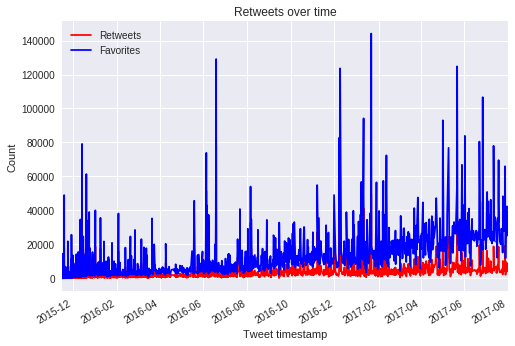

In [346]:
import matplotlib.pyplot as plt
df['retweet_count'].plot(color = 'red', label='Retweets')
df['favorite_count'].plot(color = 'blue', label='Favorites')

plt.legend(loc='upper left')
plt.xlabel('Tweet timestamp')
plt.ylabel('Count')
plt.title('Retweets over time')
plt.savefig('retweets_favorites.png')
plt.show()